# A/B Hypothesis Testing

## Import Dependencies

In [1]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join('..')))

## Load Modules

In [2]:
from src.data_loader import DataLoader
from src.hypothesis_tests import HypothesisTester

file_path = '../data/raw/MachineLearningRating_v3.txt'

## Load File

In [3]:
loader = DataLoader(file_path)
df = loader.load_data()

# Basic Prep (Standardizing Gender for the test)
df['Gender'] = df['Gender'].replace({'Male': "M", 'Female': 'F'})
df = df[df['Gender'].isin(['M', 'F'])] # Filter out unknowns for the A/B test

tester = HypothesisTester(df)
processed_df = tester.get_data()
print(processed_df[['TotalPremium', 'TotalClaims', 'Margin', 'Claimed']].head())

INFO:src.data_loader:Data loaded successfully.


       TotalPremium  TotalClaims     Margin  Claimed
28622     15.789474          0.0  15.789474        0
28623     15.789474          0.0  15.789474        0
28624     15.789474          0.0  15.789474        0
28625     15.789474          0.0  15.789474        0
28626      2.038421          0.0   2.038421        0


## Risk Differences across Provinces

- Null Hypothesis (H0): There are no risk differences across provinces.


TEST: H0: No Risk Difference Across Provinces
------------------------------------------------------------
P-Value:      0.00536
Threshold:    0.05
Decision:     REJECT Null Hypothesis
ACTION:       Implement Territorial Rating. Apply a risk loading factor (e.g., 1.2x) to high-claim provinces like Gauteng.



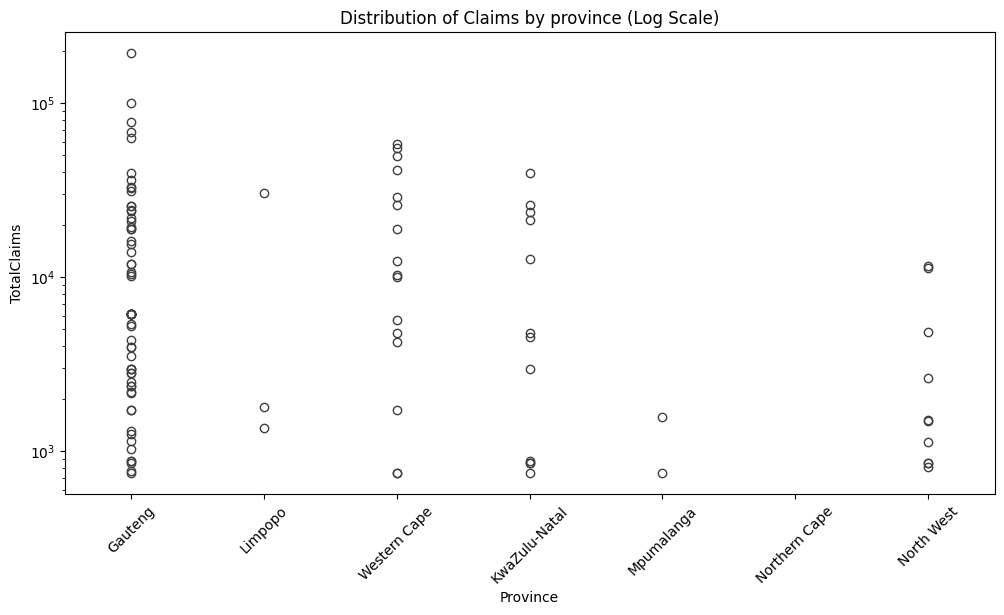

In [5]:
# We test "TotalClaims" (Severity) across all provinces using ANOVA logic inside our class

# tester.test_risk_by_group('Province', metric='TotalClaims')
tester.test_province_risk()
# Visualization
plt.figure(figsize=(12, 6))
sns.boxplot(x='Province', y='TotalClaims', data=df)
plt.yscale('log') # Log scale because claims vary wildly
plt.title('Distribution of Claims by province (Log Scale)')
plt.xticks(rotation=45)
plt.show()

## Risk Differences between Zip codes

- Null Hypothesis (H0): There are no risk differences between zip codes.

In [8]:
# Data segmentation: Select top 2 zip codes by volume to simulate A/B testing
top_zips = df['PostalCode'].value_counts().head(2).index.to_list()

# Creat Control/Test Groups
zip_df = df[df['PostalCode'].isin(top_zips)]
zip_tester = HypothesisTester(zip_df)

# zip_tester.test_risk_by_group('PostalCode', metric='TotalClaims')
tester.test_zip_risk()


TEST: H0: No Risk Difference Between Zip 2000 & 7800
------------------------------------------------------------
P-Value:      0.01751
Threshold:    0.05
Decision:     REJECT Null Hypothesis
ACTION:       Geographic risk is granular. Implement geo-fencing pricing models distinguishing Zip 2000 from 7800.



## Margin Differences Between Zip Codes

- Null Hypothesis (H0): There is no significant profit margin difference between zip codes.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



TEST: H0: No Margin Difference Between Zip 2000 & 7800
------------------------------------------------------------
P-Value:      0.26703
Threshold:    0.05
Decision:     FAIL TO REJECT Null Hypothesis
ACTION:       Current pricing model effectively neutralizes risk differences, maintaining consistent margins.



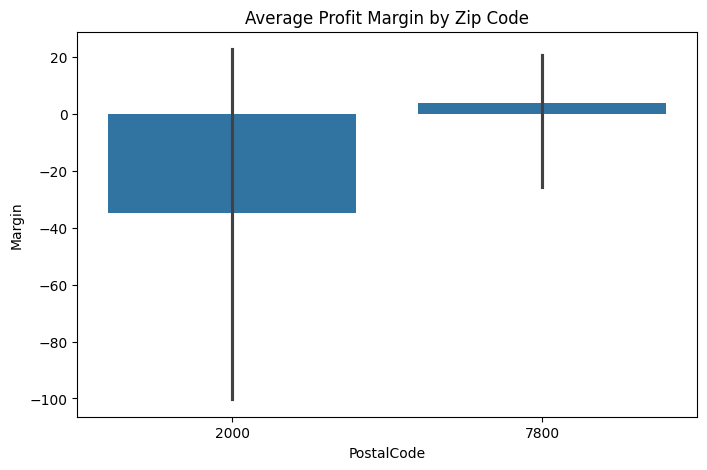

In [9]:
# Using the same top 2 zip codes, but testing 'Margin'
# zip_tester.test_risk_by_group('PostalCode', metric='Margin')
tester.test_zip_margin()
plot_data = zip_tester.df

# Visualization
plt.figure(figsize=(8, 5))
sns.barplot(x='PostalCode', y='Margin', data=plot_data)
plt.title('Average Profit Margin by Zip Code')
plt.show()

## Hypothesis 4 - Women vs Men

Null Hypothesis (H0): There is no significant risk difference between Women and Men.


TEST: H0: No Risk Difference Between Genders
------------------------------------------------------------
P-Value:      0.85413
Threshold:    0.05
Decision:     FAIL TO REJECT Null Hypothesis
ACTION:       Gender is not a predictive rating factor. Do not include in pricing model.



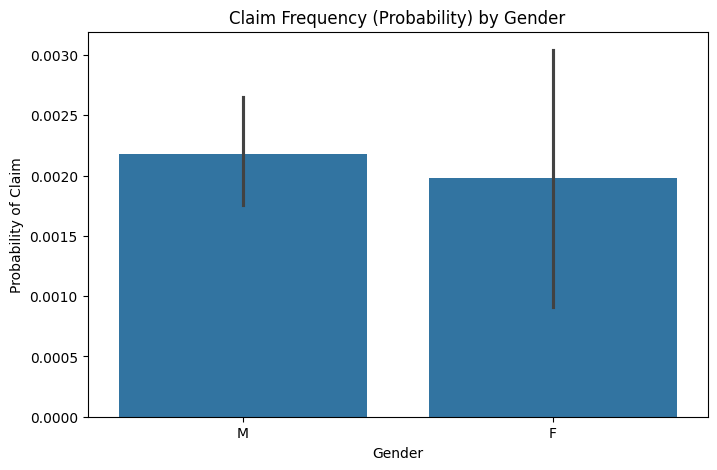

In [6]:
# Control Step: filter for homogeneous segment
segment_df = df[df['VehicleType'] == 'Passenger Vehicle']
gender_tester = HypothesisTester(segment_df)

tester.test_gender_risk()
plot_data = gender_tester.df

# Visualization
plt.figure(figsize=(8,5))
sns.barplot(x='Gender', y='Claimed', data=plot_data)
plt.title('Claim Frequency (Probability) by Gender')
plt.ylabel('Probability of Claim')
plt.show()